In [165]:
import json

import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
import numpy as np

In [166]:
path_raw_results: str = '../../benchmark_results/raw.csv'
df: pd.DataFrame = pd.read_csv(path_raw_results)

base_model_name: str = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'

## Group Data

In [167]:
columns_to_keep_raw_csv: list = ['game', 'model', 'experiment', 'episode', 'Aborted', 'Lose', 'Success']

def group_raw_csv(data: pd.DataFrame, columns_to_keep: list[str]) -> pd.DataFrame:
    df: pd.DataFrame = data.pivot_table(
        index=['game', 'model', 'experiment', 'episode'],
        columns=['metric'],
        values='value'
    ).reset_index()

    columns_to_drop: list = [column for column in list(df.keys()) if column not in columns_to_keep]
    return df.drop(columns=columns_to_drop, axis=0)

clean_csv_data: pd.DataFrame = group_raw_csv(data=df, columns_to_keep=columns_to_keep_raw_csv)

# utils

In [173]:
# this works for taboo, and all wordle games
def get_term_from_episode(row):
    model_name = row['model']
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']
    
    path: str = f'../../benchmark_results/{model_name}/{game}/{experiment}/{episode}/instance.json'
    instance: dict = json.load(open(path))
    return instance['target_word']

# this works for image game and referencegame and private shared
def get_generic_turn_name(row):
    experiment_name = row['experiment']
    episode = row['episode']
    return f'{experiment_name[2:]}-{episode.split("_")[1]}'

def prepare_model_names(raw_names: list) -> list:
    return [m.split("--")[0].split("-t0")[0] for m in raw_names]

def prepare_value(row):
    if row['Success'] == 1.0: return 'Success'
    if row['Lose'] == 1.0: return 'Loss'
    if row['Aborted'] == 1.0: return 'Aborted'
    return 'Undefined'

def prepare_model_data(model_name, data_frame: pd.DataFrame, get_turn_name) -> pd.DataFrame:
    df: pd.DataFrame = data_frame[data_frame.model == model_name]
    data_base_model: dict = {}
    
    for index, row in df.iterrows():
        data_base_model.update({get_turn_name(row): prepare_value(row)})
        
    return data_base_model


def reorder_columns(df: pd.DataFrame) -> pd.DataFrame:
    original_columns = df.columns.tolist()
    running_columns = df.columns.tolist()
    rearranged_columns = []

    ## collect all values that are aborted
    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Aborted':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    ## collect all values that are aborted
    for column in running_columns:
        if df[column].iloc[0] == 'Aborted':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Loss':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if df[column].iloc[0] == 'Loss':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Success':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if df[column].iloc[0] == 'Success':
            rearranged_columns.append(column)

    assert len(rearranged_columns) == len(original_columns)

    return rearranged_columns, original_columns

In [184]:
# list of all games
games = list(set(list(clean_csv_data.game)))

# only consider these models for eval
models_to_consider: list = ['Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0',
                            'llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e1-_E1_D10001-t0.0',
                            'llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e1-_E1_D20001-t0.0',
                            'llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e1-_E1_D20002-t0.0',
                            'llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e1-_E1_D20003-t0.0',
                            'llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e1-_E1_D30001-t0.0',
                            'llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e1-_E1_D30002-t0.0',
                            'llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e1-_E1_D30003-t0.0',
                            'llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e1-_E1_D30004-t0.0']

turn_extraction_lookup = {
    'wordle': get_term_from_episode,
    'wordle_withclue': get_term_from_episode,
    'wordle_withcritic': get_term_from_episode,
    'taboo': get_term_from_episode,
    'imagegame': get_generic_turn_name,
    'referencegame': get_generic_turn_name,
    'privateshared': get_generic_turn_name,
}

custom_height_lookup = {
    'wordle': 3,
    'wordle_withclue': 3,
    'wordle_withcritic': 3,
    'taboo': 3.7,
    'imagegame': 3.8,
    'referencegame': 4.5,
    'privateshared': 3.7,
}

## Set up the plotting

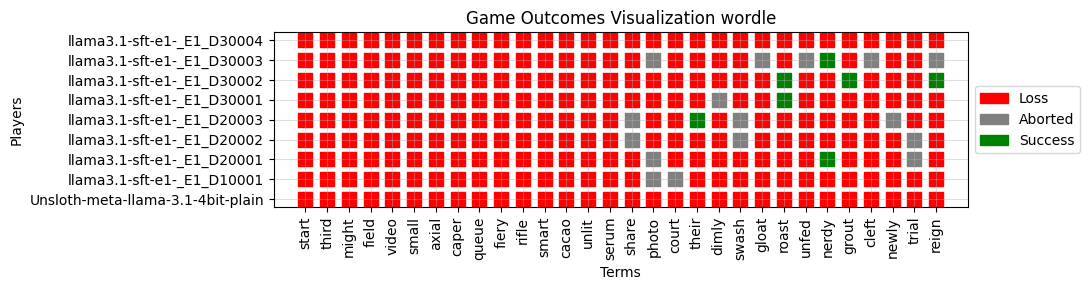

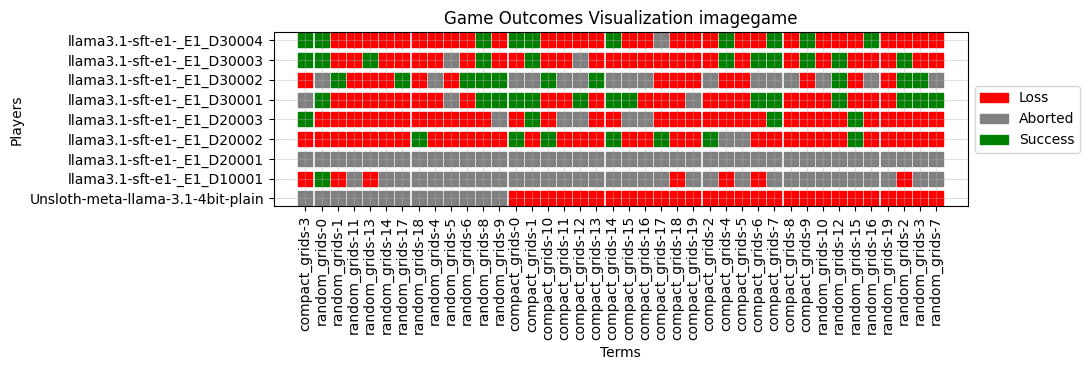

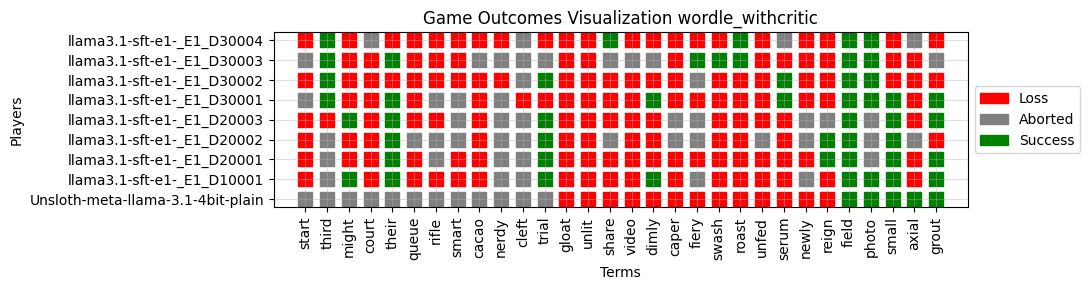

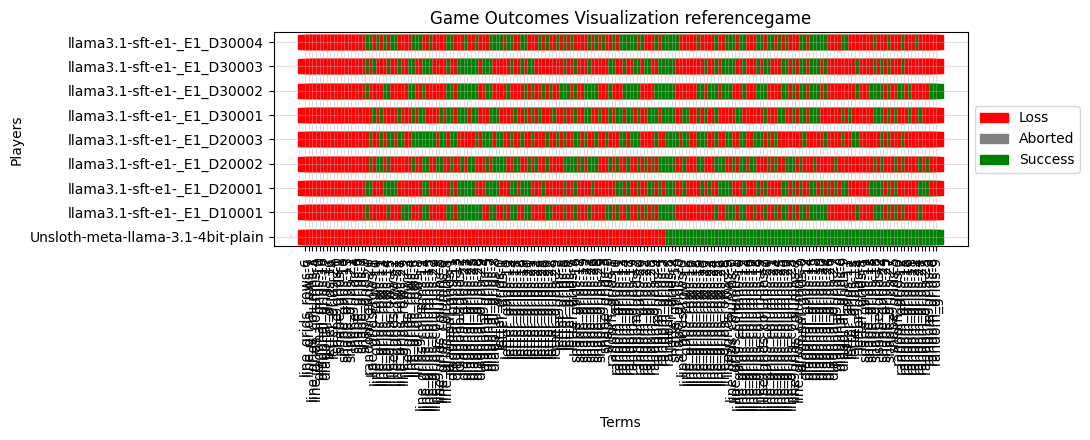

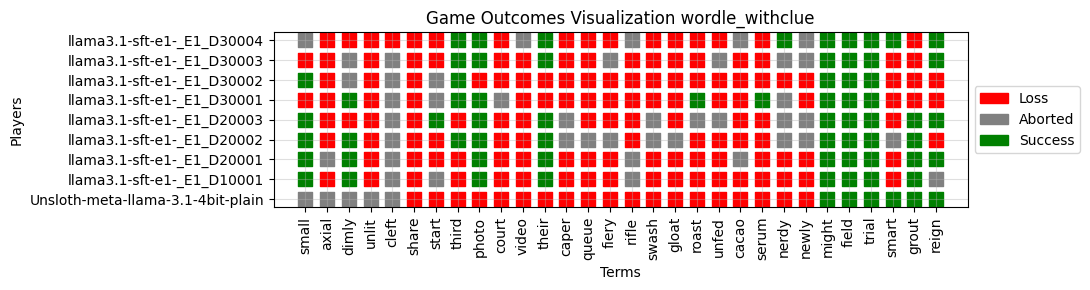

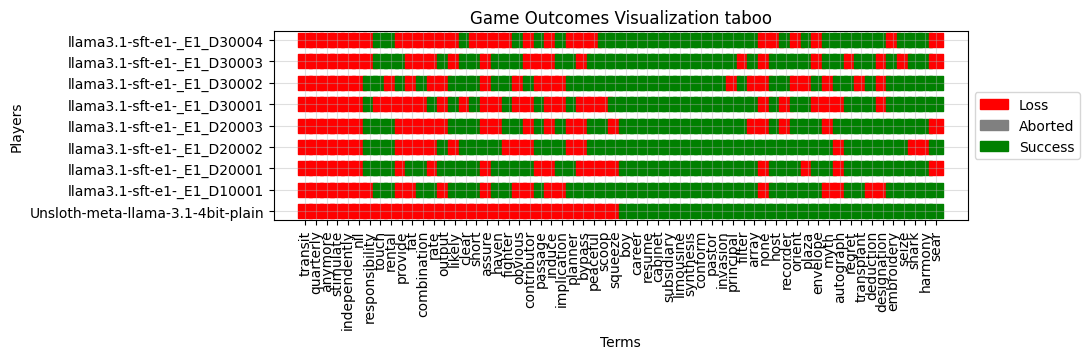

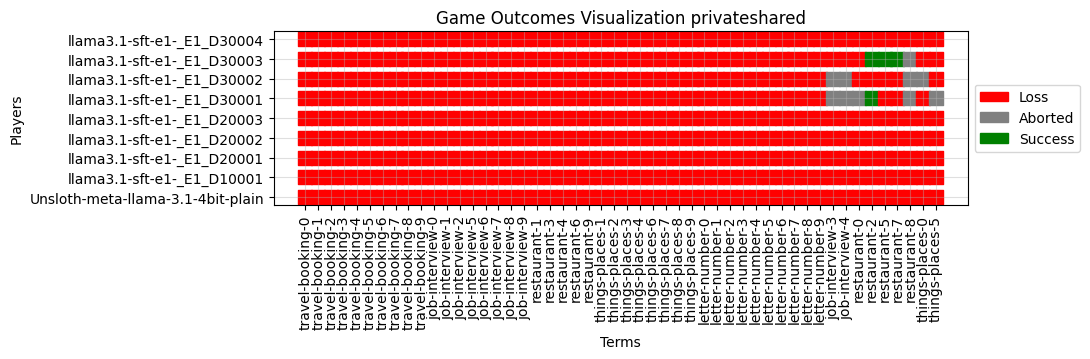

In [185]:
for game in games:
    game_data = clean_csv_data[clean_csv_data.game == game]

    plot_data: dict = {}
    for model_name, short_name in zip(models_to_consider, prepare_model_names(models_to_consider)):
        prep_data = prepare_model_data(model_name, game_data, turn_extraction_lookup[game])
        plot_data.update({short_name: prep_data})
    
    
    df = pd.DataFrame(plot_data)
    df_transposed = df.T
    
    reordered_columns, original_columns = reorder_columns(df_transposed)
    df_reordered = df_transposed[reordered_columns].T

    # Sample data
    players = prepare_model_names(models_to_consider)
    terms = list(df_reordered.index)
    
    # Create a dictionary to map outcomes to colors
    color_map = {'Success': 'green', 'Loss': 'red', 'Aborted': 'gray', 'Undefined': 'lightblue'}
    
    # Sample data structure (replace with your actual data)
    data = df_reordered
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(11, custom_height_lookup[game]))
    
    # Plot data points
    for i, player in enumerate(players):
        for j, term in enumerate(terms):
            outcome = data[player][term]
            ax.scatter(j, i, color=color_map[outcome], s=100, marker='s')
    
    # Customize axes
    ax.set_xticks(range(len(terms)))
    ax.set_xticklabels(terms)
    plt.xticks(rotation=90)
    
    ax.set_yticks(range(len(players)))
    ax.set_yticklabels(players)
    
    # Add labels and title
    ax.set_xlabel('Terms')
    ax.set_ylabel('Players')
    ax.set_title(f'Game Outcomes Visualization {game}')
    
    # Add a grid for better readability
    ax.grid(True, linestyle='-', alpha=0.4)
    
    
    # Creating legend with color box
    color_box_loss = mpatches.Patch(color='red', label='Loss')
    color_box_aborted = mpatches.Patch(color='gray', label='Aborted')
    color_box_success = mpatches.Patch(color='green', label='Success')
    
    plt.legend(handles=[color_box_loss, color_box_aborted, color_box_success],loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    plt.tight_layout()
    plt.savefig(f'../../plots/success_abort_rate_{game}.png')
    plt.show()

In [186]:
clean_csv_data.head()

metric,game,model,experiment,episode,Aborted,Lose,Success
0,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_0,1.0,0.0,0.0
1,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_1,1.0,0.0,0.0
2,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_10,1.0,0.0,0.0
3,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_11,1.0,0.0,0.0
4,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_12,1.0,0.0,0.0


In [200]:
all_games = list(clean_csv_data.game.unique())
columns_to_keep = ['game', 'model', 'Aborted', 'Lose', 'Success']
cleaned_data = clean_csv_data[columns_to_keep]
cleaned_data = cleaned_data[cleaned_data.model.isin(models_to_consider)]

In [201]:
cleaned_data.groupby(['game', 'model']).agg({'Aborted': 'sum', 'Lose': 'sum', 'Success': 'sum'})

metric                                                                Aborted  \
game              model                                                         
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...     13.0   
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...     32.0   
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...     40.0   
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...      2.0   
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      5.0   
...                                                                       ...   
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      8.0   
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...      4.0   
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...      2.0   
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...      9.0   
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...      4.0   

metric                                                                Lose  \
game              model                                                      
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...  27.0   
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...   7.0   
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...   0.0   
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...  31.0   
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...  31.0   
...                                                                    ...   
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...  16.0   
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...  18.0   
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...  23.0   
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...  14.0   
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...  21.0   

metric                                                                Success  
game              model                                                        
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...      0.0  
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...      1.0  
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...      0.0  
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...      7.0  
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      4.0  
...                                                                       ...  
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      6.0  
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...      8.0  
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...      5.0  
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...      7.0  
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...      5.0  

[63 rows x 3 columns]

In [210]:
# Assuming you've already performed the groupby and aggregation
aggregated_data = cleaned_data.groupby(['game', 'model']).agg({'Aborted': 'sum', 'Lose': 'sum', 'Success': 'sum'})

# Calculate the total attempts for each group
aggregated_data['Total'] = aggregated_data['Aborted'] + aggregated_data['Lose'] + aggregated_data['Success']

# Calculate the ratios
aggregated_data['Success_ratio'] = aggregated_data['Success'] / aggregated_data['Total']
aggregated_data['Lose_ratio'] = aggregated_data['Lose'] / aggregated_data['Total']
aggregated_data['Aborted_ratio'] = aggregated_data['Aborted'] / aggregated_data['Total']

# Reset the index if you want 'game' and 'model' as columns
aggregated_data = aggregated_data.reset_index()

In [211]:
aggregated_data.head()

metric,game,model,Aborted,Lose,Success,Total,Success_ratio,Lose_ratio,Aborted_ratio
0,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,13.0,27.0,0.0,40.0,0.000,0.675,0.325
1,imagegame,llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-...,32.0,7.0,1.0,40.0,0.025,0.175,0.800
2,imagegame,llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-...,40.0,0.0,0.0,40.0,0.000,0.000,1.000
3,imagegame,llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-...,2.0,31.0,7.0,40.0,0.175,0.775,0.050
4,imagegame,llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-...,5.0,31.0,4.0,40.0,0.100,0.775,0.125


In [ ]:
aggregated_data['model'].apply(lambda x: mod(x))

/var/folders/qh/qhq087rn6n9bnym2l00z7qyw0000gn/T/ipykernel_96176/1168276079.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


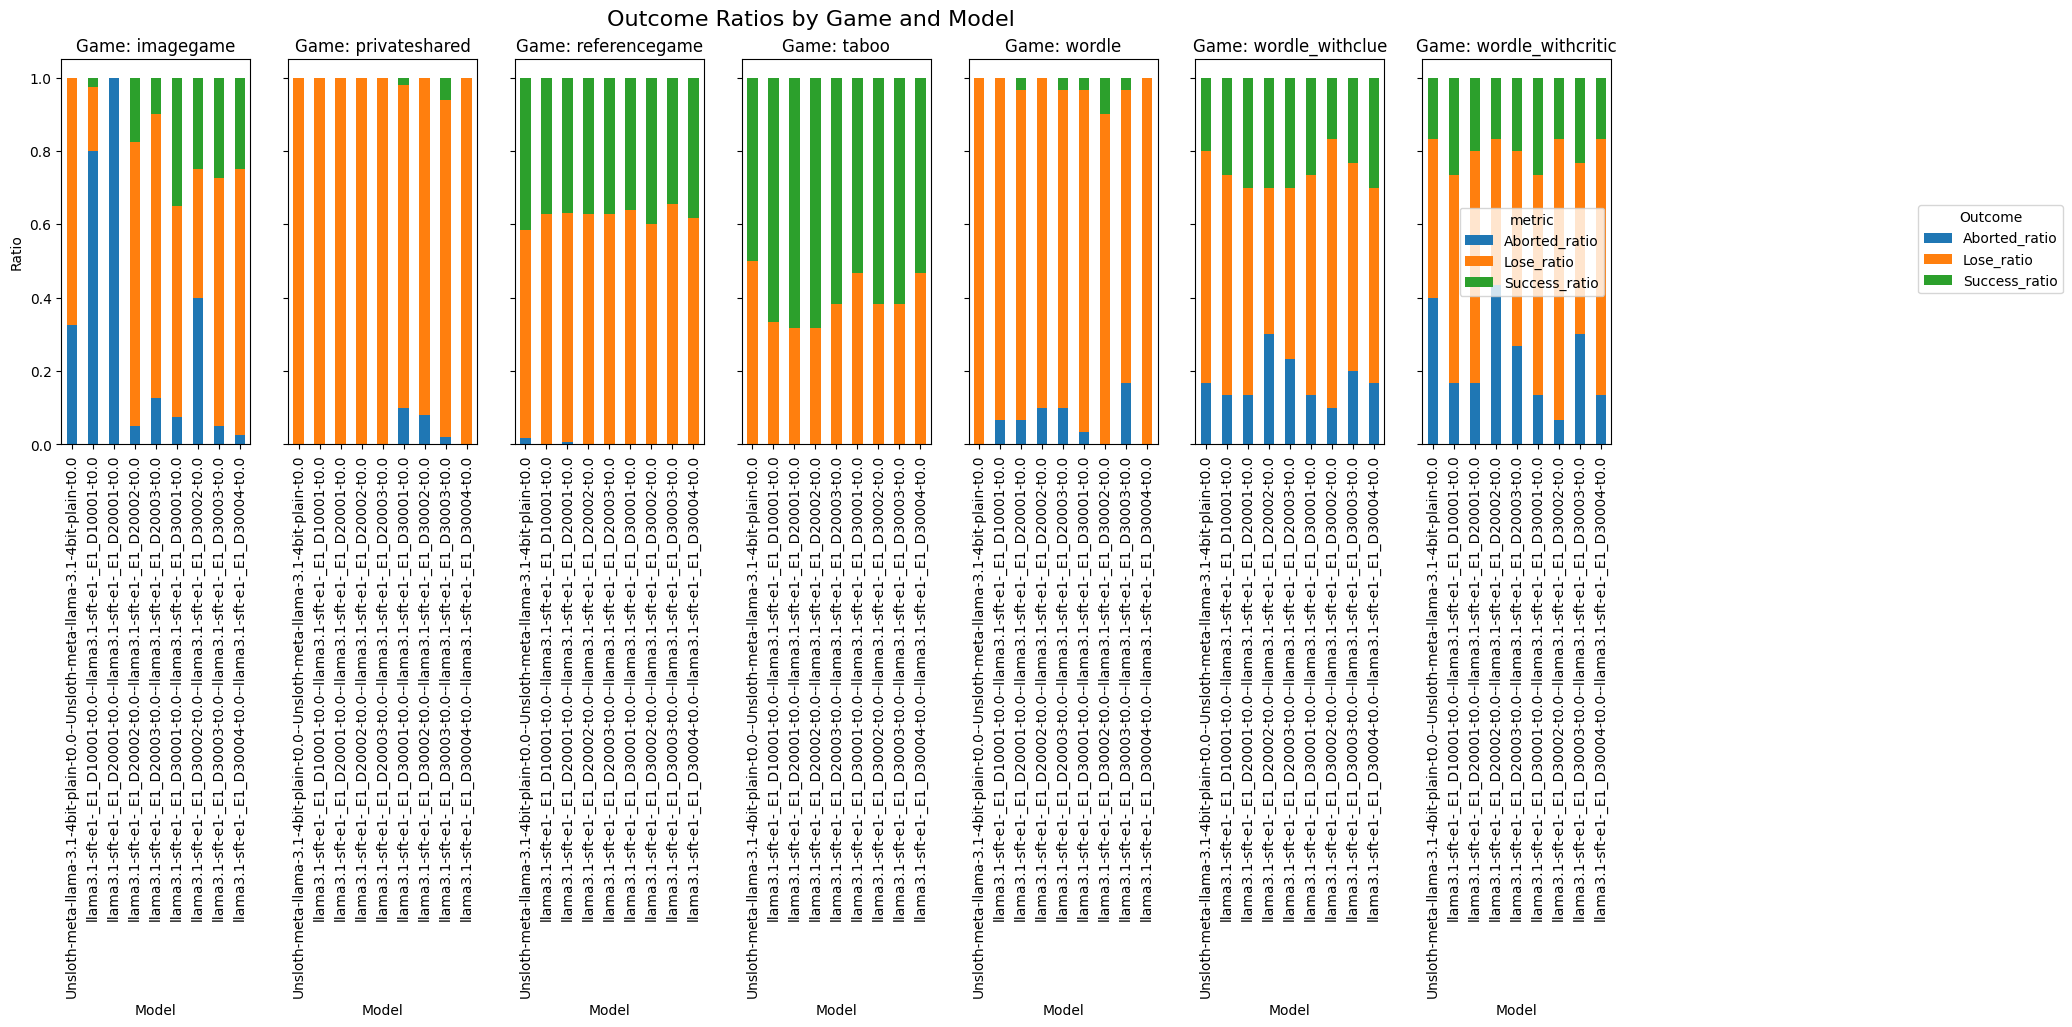

In [216]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure with subplots for each game
games = aggregated_data['game'].unique()
fig, axes = plt.subplots(1, len(games), figsize=(20, 5), sharey=True)
fig.suptitle('Outcome Ratios by Game and Model', fontsize=16)

# Iterate through games and create a stacked bar chart for each
for i, game in enumerate(games):
    game_data = aggregated_data[aggregated_data['game'] == game]

    game_data.plot(x='model', y=['Aborted_ratio', 'Lose_ratio', 'Success_ratio'],
                   kind='bar', stacked=True, ax=axes[i])

    axes[i].set_title(f'Game: {game}')
    axes[i].set_xlabel('Model')
    if i == 0:
        axes[i].set_ylabel('Ratio')
    else:
        axes[i].set_ylabel('')

    # Remove legend for all but the last subplot
    if i < len(games) - 1:
        axes[i].get_legend().remove()

# Adjust the legend
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title='Outcome', bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.show()


In [209]:
aggregated_data.head()

,Unsloth-meta-llama-3.1-4bit-plain,llama3.1-sft-e1-_E1_D10001,llama3.1-sft-e1-_E1_D20001,llama3.1-sft-e1-_E1_D20002,llama3.1-sft-e1-_E1_D20003,llama3.1-sft-e1-_E1_D30001,llama3.1-sft-e1-_E1_D30002,llama3.1-sft-e1-_E1_D30003,llama3.1-sft-e1-_E1_D30004
travel-booking-0,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss
travel-booking-1,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss
travel-booking-2,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss
travel-booking-3,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss
travel-booking-4,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss,Loss
